In [2]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

path = Path(os.getcwd()).parent

In [3]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):

    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax) + EPSILON).astype('float64')
    
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(drop, preds, 1)

    return probas[0]

def batch_split(df: pd.DataFrame,
                split_size: int = 5):
    
    df.groupby(np.arange(len(df))//split_size)
    
    return [g for _,g in df.groupby(np.arange(len(df))//split_size)]

def rocch(fpr0, tpr0):
    """
    copied from: https://github.com/foxtrotmike/rocch/blob/master/roc.py
    -- no licence specified.
    @author: Dr. Fayyaz Minhas (http://faculty.pieas.edu.pk/fayyaz/)
    Construct the convex hull of a Receiver Operating Characteristic (ROC) curve
        Input:
            fpr0: List of false positive rates in range [0,1]
            tpr0: List of true positive rates in range [0,1]
                fpr0,tpr0 can be obtained from sklearn.metrics.roc_curve or 
                    any other packages such as pyml
        Return:
            F: list of false positive rates on the convex hull
            T: list of true positive rates on the convex hull
                plt.plot(F,T) will plot the convex hull
            auc: Area under the ROC Convex hull
    """
    fpr = np.array([0]+list(fpr0)+[1.0,1,0])
    tpr = np.array([0]+list(tpr0)+[1.0,0,0])
    hull = ConvexHull(np.vstack((fpr,tpr)).T)
    vert = hull.vertices
    vert = vert[np.argsort(fpr[vert])]  
    F = [0]
    T = [0]
    for v in vert:
        ft = (fpr[v],tpr[v])
        if ft==(0,0) or ft==(1,1) or ft==(1,0):
            continue
        F+=[fpr[v]]
        T+=[tpr[v]]
    F+=[1]
    T+=[1]
    auc = np.trapz(T,F)
    return F,T,auc

def plot_auc_temp(aucs, temperatures):
    for auc_score, temp in zip(aucs, temperatures):
        plt.plot(auc_score, color='black', label='AUC')
        plt.plot(len(auc_score)*[0.5], color='darkblue', linestyle='--', label='random')
        plt.ylabel('AUC')
        plt.xlabel('Number of removed observations')
        plt.title(f'MRS with temperature={temp}')
        plt.legend()
        plt.savefig(f'MRS_{temp}.pdf')
        plt.show()

def plot_roc(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# MRS Algorithm

To allow statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [4]:
def MRS(N: pd.DataFrame, 
        R: pd.DataFrame,
        columns: list,
        clf,
        split_size: int=250,
        temperature: float=0.5,
        n_drop: int=1,
        k: int=1):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * columns: features to consider when sampling and training.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * limit: number of remaining samples in nonrep used as stopping criterion.
        * ensemble_size: models per iteration.
        * k: bootstrap size factor (usually k=1 or k>1).
    
    Output:
        * AUC: list of AUC for each iteration.
    """
    AUC = []
    
    N['label'] = 1
    R['label'] = 0

    df = pd.concat([N, R], sort=True)

    N_splits = batch_split(N, split_size)

    preds = []
    for i in range(len(N_splits)):

        N_test = N_splits[i]
        N_train = pd.concat(N_splits[:i] + N_splits[i+1:])

        n = min(len(N), len(R))

        bootstrap = pd.concat([N_train.sample(n=n*k, replace=True),
                               R.sample(n=n*k, replace=True)], sort=True)
        
        clf.fit(bootstrap[columns], bootstrap.label)
        preds.extend(clf.predict_proba(N_test[columns])[:,1])  # probability that N_test comes from N not R

    return N[[True if drop==0 else False for drop in temperature_sample(preds, temperature, n_drop)]]

In [5]:
def repeated_MRS(df, columns, clf, temperatures, number_of_iterations=100, split_size=255, n_drop=5, k=1, test_size=0.33):

    aucs = []
    for temp in temperatures:

        N = df[df["label"] == 1].copy()
        R = df[df["label"] == 0].copy()
        auc = []

        for _ in range(number_of_iterations):

            N = MRS(N,
                    R,
                    columns,
                    clf,
                    split_size=split_size,
                    temperature=temp,
                    n_drop=n_drop,
                    k=k)

            data = pd.concat([N, R])
            X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label, test_size=test_size)

            clf = CalibratedClassifierCV(LinearSVC(C=0.53, max_iter=2**20, dual=False))
            clf.fit(X_train, y_train)

            auc.append(roc_auc_score(y_test, clf.predict_proba(X_test[columns])[:,1]))

        # print(N['Above/Below 50K'].value_counts())  # only for US Census experiment
        aucs.append(auc)
        print(data['label'].value_counts())

    return aucs

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [53]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

train = pd.read_csv(os.path.join(path, 'data/census_income/adult.data'), names=columns)
test = pd.read_csv(os.path.join(path, 'data/census_income/adult.test'), names=columns)
test = test.iloc[1:]

df = pd.concat([train, test]).copy(deep=True)

del train, test

df.replace(' >50K.', ' >50K', inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

ctg = ['Workclass', 'Sex', 'Education', 'Marital Status', 
       'Occupation', 'Relationship', 'Race', 'Country']
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)

'''Rep: <=50K    37155 ;; >50K     11687'''

df_high = df[df['Above/Below 50K'] == " >50K"].copy(deep=True)
df_low = df[df['Above/Below 50K'] == " <=50K"].copy(deep=True)

df_low = df_low.reindex(np.random.permutation(df_low.index))
df_high = df_high.reindex(np.random.permutation(df_high.index))

#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_low.head(2000).copy(deep=True),
                 df_high.head(2000).copy(deep=True)], sort=True)

nonrep = pd.concat([df_low.tail(2000).copy(deep=True),
                    df_high.tail(2000).copy(deep=True)], sort=True)
#----------------------------------------------------------------------#
#-----------------Simulate (already) representative data---------------#
#rep = pd.concat([df_low.head(2000).copy(deep=True),
#                 df_high.head(2000).copy(deep=True)], sort=True)
#
#nonrep = pd.concat([df_low.tail(3000).copy(deep=True),
#                    df_high.tail(1000).copy(deep=True)], sort=True)
#----------------------------------------------------------------------#

print("Current setting:")
print('Rep: \n', rep['Above/Below 50K'].value_counts(), '\n')
print('Nonrep: \n', nonrep['Above/Below 50K'].value_counts())

nonrep['label'] = 1
rep['label'] = 0

del df, df_low, df_high

us = pd.concat([nonrep, rep], sort=True)

us_columns = list(us.columns)
meta = ['label', 'Above/Below 50K', 'index', 'bootstrap']
for m in meta:
    if m in us_columns:
        us_columns.remove(m)

scale = StandardScaler()
us['fnlgwt'] = scale.fit_transform(us.fnlgwt.values.reshape(-1, 1))
us['Age'] = scale.fit_transform(us.fnlgwt.values.reshape(-1, 1))
us['Capital Loss'] = scale.fit_transform(us['Capital Loss'].values.reshape(-1, 1))
us['Capital Gain'] = scale.fit_transform(us['Capital Gain'].values.reshape(-1, 1))

us.reset_index(drop=True, inplace=True)
us.head()

Current setting:
Rep: 
  <=50K    2000
 >50K     2000
Name: Above/Below 50K, dtype: int64 

Nonrep: 
  <=50K    2000
 >50K     2000
Name: Above/Below 50K, dtype: int64


,Above/Below 50K,Age,Capital Gain,Capital Loss,Country_ ?,Country_ Cambodia,Country_ Canada,Country_ China,Country_ Columbia,Country_ Cuba,...,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,fnlgwt,label
0,<=50K,-0.042750,-0.196222,-0.262812,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-0.042750,1
1,<=50K,-0.999465,-0.196222,-0.262812,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-0.999465,1
2,<=50K,-0.213950,-0.196222,-0.262812,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.213950,1
3,<=50K,-0.023759,-0.196222,-0.262812,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.023759,1
4,<=50K,-0.365731,-0.196222,-0.262812,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.365731,1


### Hyperparameter Tuning
*Expected Output (might vary slightly due to randomness):*
##### LinearSVC(C=0.03276616, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1048576, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [12]:
N = us[us["label"] == 1].copy()
R = us[us["label"] == 0].copy()

X_train = pd.concat([N.head(len(N)//2), R.head(len(N)//2)])
X_test = pd.concat([N.tail(len(N)//2), R.tail(len(N)//2)])

y = (len(N)//2)*[1] + (len(N)//2)*[0]

#param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0,5, 1, 5, 10, 20, 100]}
mu, sigma = 0.01, 0.1 # mean and standard deviation
param_grid = {'C': np.random.normal(mu, sigma, 100)}

grid = GridSearchCV(LinearSVC(max_iter=2**20, dual=False), param_grid, verbose=3, cv=3)
grid.fit(X_train[us_columns], y)

print(grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=0.10909918357656548 ...........................................
[CV] ............... C=0.10909918357656548, score=0.506, total=   0.0s
[CV] C=0.10909918357656548 ...........................................
[CV] ............... C=0.10909918357656548, score=0.493, total=   0.0s
[CV] C=0.10909918357656548 ...........................................
[CV] ............... C=0.10909918357656548, score=0.486, total=   0.0s
[CV] C=0.19517168728040124 ...........................................
[CV] ............... C=0.19517168728040124, score=0.504, total=   0.0s
[CV] C=0.19517168728040124 ...........................................
[CV] ............... C=0.19517168728040124, score=0.496, total=   0.0s
[CV] C=0.19517168728040124 ...........................................
[CV] ............... C=0.19517168728040124, score=0.487, total=   0.0s
[CV] C=-0.027679991026898894 .........................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.027679991026898894)

  FitFailedWarning)


[CV] ............... C=0.07055836045962743, score=0.505, total=   0.0s
[CV] C=0.07055836045962743 ...........................................
[CV] ............... C=0.07055836045962743, score=0.492, total=   0.0s
[CV] C=0.07055836045962743 ...........................................
[CV] ............... C=0.07055836045962743, score=0.485, total=   0.0s
[CV] C=-0.06324995954099538 ..........................................
[CV] ................ C=-0.06324995954099538, score=nan, total=   0.0s
[CV] C=-0.06324995954099538 ..........................................
[CV] ................ C=-0.06324995954099538, score=nan, total=   0.0s
[CV] C=-0.06324995954099538 ..........................................
[CV] ................ C=-0.06324995954099538, score=nan, total=   0.0s
[CV] C=-0.07611331018134133 ..........................................
[CV] ................ C=-0.07611331018134133, score=nan, total=   0.0s
[CV] C=-0.07611331018134133 ..........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.06324995954099538)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.07611331018134133)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.22273822486057707)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_va

[CV] .............. C=0.033861400219985675, score=0.484, total=   0.0s
[CV] C=-0.03960927984765198 ..........................................
[CV] ................ C=-0.03960927984765198, score=nan, total=   0.0s
[CV] C=-0.03960927984765198 ..........................................
[CV] ................ C=-0.03960927984765198, score=nan, total=   0.0s
[CV] C=-0.03960927984765198 ..........................................
[CV] ................ C=-0.03960927984765198, score=nan, total=   0.0s
[CV] C=0.14558717401363921 ...........................................
[CV] ............... C=0.14558717401363921, score=0.503, total=   0.0s
[CV] C=0.14558717401363921 ...........................................
[CV] ............... C=0.14558717401363921, score=0.492, total=   0.0s
[CV] C=0.14558717401363921 ...........................................
[CV] ............... C=0.14558717401363921, score=0.487, total=   0.0s
[CV] C=0.01808668617488483 ...........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.0732874892546136)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.0628608081086175)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.011129920851658462)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_val


[CV] C=0.007906868520323544 ..........................................
[CV] .............. C=0.007906868520323544, score=0.482, total=   0.0s
[CV] C=-0.011129920851658462 .........................................
[CV] ............... C=-0.011129920851658462, score=nan, total=   0.0s
[CV] C=-0.011129920851658462 .........................................
[CV] ............... C=-0.011129920851658462, score=nan, total=   0.0s
[CV] C=-0.011129920851658462 .........................................
[CV] ............... C=-0.011129920851658462, score=nan, total=   0.0s
[CV] C=-0.11638432186393476 ..........................................
[CV] ................ C=-0.11638432186393476, score=nan, total=   0.0s
[CV] C=-0.11638432186393476 ..........................................
[CV] ................ C=-0.11638432186393476, score=nan, total=   0.0s
[CV] C=-0.11638432186393476 ..........................................
[CV] ................ C=-0.11638432186393476, score=nan, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.062368687425950024)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.04882831224012879)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.04148873789218208)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ............... C=0.04951363120028547, score=0.493, total=   0.0s
[CV] C=0.04951363120028547 ...........................................
[CV] ............... C=0.04951363120028547, score=0.484, total=   0.0s
[CV] C=-0.07576621948128373 ..........................................
[CV] ................ C=-0.07576621948128373, score=nan, total=   0.0s
[CV] C=-0.07576621948128373 ..........................................
[CV] ................ C=-0.07576621948128373, score=nan, total=   0.0s
[CV] C=-0.07576621948128373 ..........................................
[CV] ................ C=-0.07576621948128373, score=nan, total=   0.0s
[CV] C=-0.02859798873565167 ..........................................
[CV] ................ C=-0.02859798873565167, score=nan, total=   0.0s
[CV] C=-0.02859798873565167 ..........................................
[CV] ................ C=-0.02859798873565167, score=nan, total=   0.0s
[CV] C=-0.02859798873565167 ..........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.015095496591164248)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.14701186248444523)

  FitFailedWarning)



[CV] C=0.12019882829981451 ...........................................
[CV] ............... C=0.12019882829981451, score=0.504, total=   0.0s
[CV] C=0.12019882829981451 ...........................................
[CV] ............... C=0.12019882829981451, score=0.493, total=   0.0s
[CV] C=0.12019882829981451 ...........................................
[CV] ............... C=0.12019882829981451, score=0.486, total=   0.0s
[CV] C=0.0784147618093727 ............................................
[CV] ................ C=0.0784147618093727, score=0.506, total=   0.0s
[CV] C=0.0784147618093727 ............................................
[CV] ................ C=0.0784147618093727, score=0.489, total=   0.0s
[CV] C=0.0784147618093727 ............................................
[CV] ................ C=0.0784147618093727, score=0.485, total=   0.0s
[CV] C=-0.05144675509186545 ..........................................
[CV] ................ C=-0.05144675509186545, score=nan, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.05144675509186545)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.13825903734934564)

  FitFailedWarning)


[CV] ................ C=0.1375634422771701, score=0.487, total=   0.0s
[CV] C=0.03597782262503411 ...........................................
[CV] ............... C=0.03597782262503411, score=0.511, total=   0.0s
[CV] C=0.03597782262503411 ...........................................
[CV] ............... C=0.03597782262503411, score=0.492, total=   0.0s
[CV] C=0.03597782262503411 ...........................................
[CV] ............... C=0.03597782262503411, score=0.486, total=   0.0s
[CV] C=0.000628681449235894 ..........................................
[CV] .............. C=0.000628681449235894, score=0.512, total=   0.0s
[CV] C=0.000628681449235894 ..........................................
[CV] .............. C=0.000628681449235894, score=0.491, total=   0.0s
[CV] C=0.000628681449235894 ..........................................
[CV] .............. C=0.000628681449235894, score=0.481, total=   0.0s
[CV] C=0.07554387500222634 ...........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.026722854213041325)

  FitFailedWarning)



[CV] C=0.23622301311767108 ...........................................
[CV] ............... C=0.23622301311767108, score=0.495, total=   0.0s
[CV] C=0.23622301311767108 ...........................................
[CV] ............... C=0.23622301311767108, score=0.487, total=   0.0s
[CV] C=0.17145713931840537 ...........................................
[CV] ............... C=0.17145713931840537, score=0.504, total=   0.0s
[CV] C=0.17145713931840537 ...........................................
[CV] ............... C=0.17145713931840537, score=0.494, total=   0.0s
[CV] C=0.17145713931840537 ...........................................
[CV] ............... C=0.17145713931840537, score=0.487, total=   0.0s
[CV] C=0.05057809541705203 ...........................................
[CV] ............... C=0.05057809541705203, score=0.511, total=   0.0s
[CV] C=0.05057809541705203 ...........................................
[CV] ............... C=0.05057809541705203, score=0.494, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.2528321829910665)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.11732096992485817)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.08468776111855238)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_val


[CV] C=0.13051041841741626 ...........................................
[CV] ............... C=0.13051041841741626, score=0.502, total=   0.0s
[CV] C=0.13051041841741626 ...........................................
[CV] ............... C=0.13051041841741626, score=0.492, total=   0.0s
[CV] C=0.13051041841741626 ...........................................
[CV] ............... C=0.13051041841741626, score=0.487, total=   0.0s
[CV] C=0.02585501296284297 ...........................................
[CV] ............... C=0.02585501296284297, score=0.512, total=   0.0s
[CV] C=0.02585501296284297 ...........................................
[CV] ............... C=0.02585501296284297, score=0.486, total=   0.0s
[CV] C=0.02585501296284297 ...........................................
[CV] ............... C=0.02585501296284297, score=0.485, total=   0.0s
[CV] C=0.08764396110567822 ...........................................
[CV] ............... C=0.08764396110567822, score=0.506, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.12589929173537895)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.02579571418533924)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.04348134611588691)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_va

[CV] ................ C=-0.04646877877852088, score=nan, total=   0.0s
[CV] C=-0.04646877877852088 ..........................................
[CV] ................ C=-0.04646877877852088, score=nan, total=   0.0s
[CV] C=-0.04646877877852088 ..........................................
[CV] ................ C=-0.04646877877852088, score=nan, total=   0.0s
[CV] C=-0.23511358514466607 ..........................................
[CV] ................ C=-0.23511358514466607, score=nan, total=   0.0s
[CV] C=-0.23511358514466607 ..........................................
[CV] ................ C=-0.23511358514466607, score=nan, total=   0.0s
[CV] C=-0.23511358514466607 ..........................................
[CV] ................ C=-0.23511358514466607, score=nan, total=   0.0s
[CV] C=0.11319080014822755 ...........................................
[CV] ............... C=0.11319080014822755, score=0.506, total=   0.0s
[CV] C=0.11319080014822755 ...........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.12618246782136644)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.09347036274511582)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.06766736606249703)

  FitFailedWarning)



[CV] ............... C=0.16185608848179472, score=0.494, total=   0.0s
[CV] C=0.16185608848179472 ...........................................
[CV] ............... C=0.16185608848179472, score=0.487, total=   0.0s
[CV] C=0.03992014766007185 ...........................................
[CV] ............... C=0.03992014766007185, score=0.511, total=   0.0s
[CV] C=0.03992014766007185 ...........................................
[CV] ............... C=0.03992014766007185, score=0.492, total=   0.0s
[CV] C=0.03992014766007185 ...........................................
[CV] ............... C=0.03992014766007185, score=0.485, total=   0.0s
[CV] C=0.015248102488107337 ..........................................
[CV] .............. C=0.015248102488107337, score=0.510, total=   0.0s
[CV] C=0.015248102488107337 ..........................................
[CV] .............. C=0.015248102488107337, score=0.492, total=   0.0s
[CV] C=0.015248102488107337 ..........................................
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.05626538086589742)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.13213867306825106)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.03230861697069226)

  FitFailedWarning)



[CV] C=-0.13213867306825106 ..........................................
[CV] ................ C=-0.13213867306825106, score=nan, total=   0.0s
[CV] C=-0.13213867306825106 ..........................................
[CV] ................ C=-0.13213867306825106, score=nan, total=   0.0s
[CV] C=-0.13213867306825106 ..........................................
[CV] ................ C=-0.13213867306825106, score=nan, total=   0.0s
[CV] C=-0.03230861697069226 ..........................................
[CV] ................ C=-0.03230861697069226, score=nan, total=   0.0s
[CV] C=-0.03230861697069226 ..........................................
[CV] ................ C=-0.03230861697069226, score=nan, total=   0.0s
[CV] C=-0.03230861697069226 ..........................................
[CV] ................ C=-0.03230861697069226, score=nan, total=   0.0s
[CV] C=0.145962081441911 .............................................
[CV] ................. C=0.145962081441911, score=0.503, total=   0.0s
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.13472989338691865)

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.07540660835973136)

  FitFailedWarning)


[CV] .............. C=0.055579353390468676, score=0.485, total=   0.1s
[CV] C=0.015277699621602485 ..........................................
[CV] .............. C=0.015277699621602485, score=0.511, total=   0.0s
[CV] C=0.015277699621602485 ..........................................
[CV] .............. C=0.015277699621602485, score=0.492, total=   0.0s
[CV] C=0.015277699621602485 ..........................................
[CV] .............. C=0.015277699621602485, score=0.483, total=   0.0s
[CV] C=0.01670453248099247 ...........................................
[CV] ............... C=0.01670453248099247, score=0.510, total=   0.0s
[CV] C=0.01670453248099247 ...........................................
[CV] ............... C=0.01670453248099247, score=0.491, total=   0.0s
[CV] C=0.01670453248099247 ...........................................
[CV] ............... C=0.01670453248099247, score=0.482, total=   0.0s
[CV] C=-0.044493924364288895 .........................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.044493924364288895)

  FitFailedWarning)



[CV] .............. C=0.059857510272029055, score=0.485, total=   0.1s
[CV] C=0.0807055647066153 ............................................
[CV] ................ C=0.0807055647066153, score=0.506, total=   0.1s
[CV] C=0.0807055647066153 ............................................
[CV] ................ C=0.0807055647066153, score=0.490, total=   0.1s
[CV] C=0.0807055647066153 ............................................
[CV] ................ C=0.0807055647066153, score=0.485, total=   0.1s
[CV] C=0.14167587056882838 ...........................................
[CV] ............... C=0.14167587056882838, score=0.503, total=   0.1s
[CV] C=0.14167587056882838 ...........................................
[CV] ............... C=0.14167587056882838, score=0.492, total=   0.0s
[CV] C=0.14167587056882838 ...........................................
[CV] ............... C=0.14167587056882838, score=0.487, total=   0.0s
[CV] C=-0.10157190474457357 ..........................................
[CV] 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Penalty term must be positive; got (C=-0.10157190474457357)

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.2s finished



[CV] C=0.031749987095272665 ..........................................
[CV] .............. C=0.031749987095272665, score=0.488, total=   0.0s
[CV] C=0.031749987095272665 ..........................................
[CV] .............. C=0.031749987095272665, score=0.483, total=   0.0s
LinearSVC(C=0.0551205941631974, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1048576, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)


## Experiment 1 a)

### Simulate non-representative data

| income      | Representative (R) | Non-Representative (N) |
|-------------|--------------------|------------------------|
| low (<=50K) | 2000               | 3000                   |
| high (>50K) | 2000               | 1000                   |

In [54]:
clf = CalibratedClassifierCV(LinearSVC(C=0.03276616, max_iter=2**20, dual=False))
temperatures = [0.1, 0.3, 0.5, 0.8, 1]

aucs1 = repeated_MRS(us, us_columns, clf, temperatures)

 >50K     1754
 <=50K    1747
Name: Above/Below 50K, dtype: int64
 <=50K    1768
 >50K     1732
Name: Above/Below 50K, dtype: int64
 >50K     1767
 <=50K    1733
Name: Above/Below 50K, dtype: int64
 >50K     1757
 <=50K    1744
Name: Above/Below 50K, dtype: int64
 <=50K    1753
 >50K     1749
Name: Above/Below 50K, dtype: int64


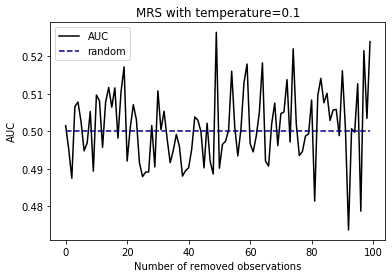

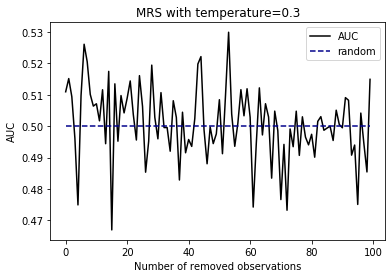

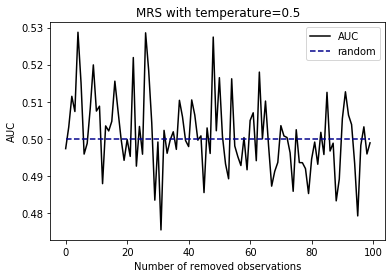

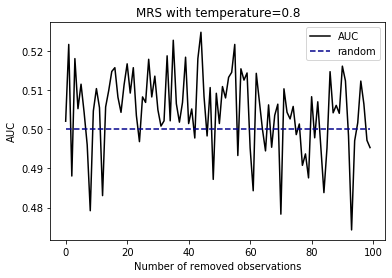

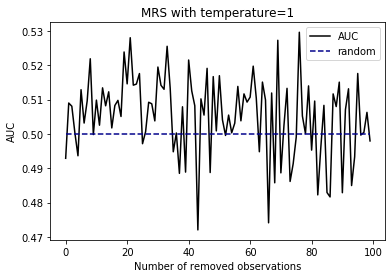

In [55]:
plot_auc_temp(aucs1, temperatures)

## Experiment 1 b)


### Simulate already representative data

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| low (<=50K) | 2000               | 2000                   |
| high (>50K) | 2000               | 2000                   |

*Here we run the MRS algorithm to test whether the ratio low-high is still maintained.*

In [30]:
clf = CalibratedClassifierCV(LinearSVC(C=0.03276616, max_iter=2**20, dual=False))
temperatures = [0.1]

aucs = repeated_MRS(us, us_columns, clf, temperatures)
plot_auc_temp(aucs2, temperatures)

 >50K     1770
 <=50K    1730
Name: Above/Below 50K, dtype: int64
 >50K     1754
 <=50K    1746
Name: Above/Below 50K, dtype: int64
 >50K     1763
 <=50K    1738
Name: Above/Below 50K, dtype: int64
 >50K     1754
 <=50K    1746
Name: Above/Below 50K, dtype: int64
 >50K     1751
 <=50K    1749
Name: Above/Below 50K, dtype: int64


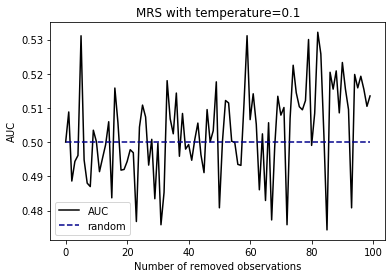

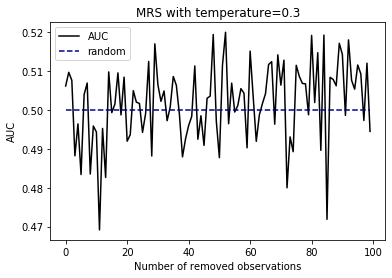

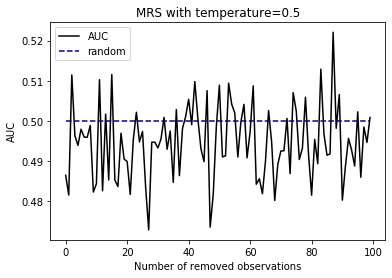

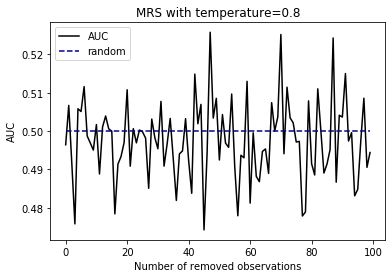

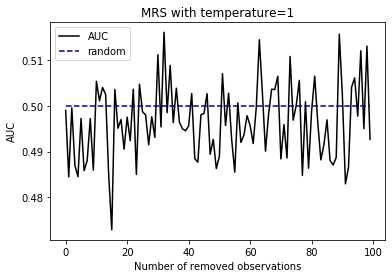

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.png" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Preprocessing GBS

**RUN ONLY ONCE - FOLLOWING CELLS WILL ALWAYS (RE-)LOAD DATA AS NEEDED**

In [6]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

gbs__ = pd.read_csv(os.path.join(path, 'data/GBS/gbs1_p.csv'), sep=" ")
gbs__.columns = ['col']

personen = []

for i in range(gbs__.shape[0]):
    person_data = str(gbs__.loc[i].values)
    if ('mehrere Personen' in person_data):
        personen.append(int (person_data.split("mehrere Personen, und zwar:\",",1)[1][0]))
    else:
        personen.append(1)
        
gbs1['am24'] = personen

df = pd.merge(gbs1, gbs2, how='inner', on=key)
df = pd.merge(df, mapping1, how='left', on=key)
df = pd.merge(df, mapping2, how='left', on=key)

attributes1 = ['am01','am02_01','am11','am10','am23','am14','am15','am17','am22','am24','am29','am27']
attributes2 = ['gh03_08','gh08_03','gh04_01','gh05_01','pt04',
               'pt03_01','pt01_02','gh07_01','gh04_01','gh03_10','gh03_07','gh03_13','gh03_11']
attributes3 = ['v2673_1_bfi_bfi1','v2673_1_bfi_bfi2','v2673_1_bfi_bfi3','v2673_1_bfi_bfi4','v2673_1_bfi_bfi5',
               'v2673_1_bfi_bfi6','v2673_1_bfi_bfi7','v2673_1_bfi_bfi8','v2673_1_bfi_bfi9','v2673_1_bfi_bfi10']
attributes4 = ['gh03_09','lo01_04','pt06_01','br01_06']

attribute_name1 = ['Geschlecht','Geburtsjahr','Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
                    'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
                    'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
attribute_name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
                    'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich']
attribute_name3 = ['Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
                    'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
attribute_name4 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']

df = df[[key] + ['Gruppe'] + attributes1 + attributes2 +  attributes3 + attributes4]
df.columns = [key] + ['Gruppe'] + attribute_name1 + attribute_name2 + attribute_name3 + attribute_name4 

df = df.sort_values(by=['GBS-CODE'])

*Almost every survey participant is counted twice in the dataframe (due to previous joins). The next code snippet gets rid of duplicate entries by merging them and avering column values. They are almost (or near) identical, so this should be fine.*

In [7]:
def merge(arr1, arr2):
    result = []
    for i,j in zip(arr1, arr2):
        if(i != i):
            result.append(j)
        else:
            result.append(i)
    return result

tmp = pd.DataFrame(columns=df.columns)

j = 0
skip = False

for i in range(len(df.Gruppe)-1):
    if(not skip):
        if(df.iloc[i]["GBS-CODE"] == df.iloc[i+1]["GBS-CODE"]):
            tmp.loc[j] = merge(df.iloc[i].values, df.iloc[i+1].values)
            j = j+1
            skip = True
        else:
            tmp.loc[j] = df.iloc[i].values
            j = j+1
    else:
        skip = False
        
df = tmp.copy()
del tmp

In [13]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

df = df.replace(rep1)
df = df.replace(rep2)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

df['Geburtsjahr'] = df['Geburtsjahr'].astype(str).str[0:4].astype(int)

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {2.0: 0, 2:0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben': 1,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 1,
       'Verwitwet/ Eing. LP verstorben': 1,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5})

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 2,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss':1,
       'Hochschulabschluss':3,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6})

di7 = {1.0: 51,
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':54,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':54,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
#df = df.replace({'Erwerbstaetigkeit': di7})

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
'700 € und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 €'                    :0,
'500 bis unter 700 €'                    :0,
'unter 300 €'                            :0,
'5000 € und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})

di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse':7,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11})


df = df.fillna(df.median())

absicht = {3:0.5, 2:0, 1:0}
df = df.replace({'Wahlabsicht': absicht})
absicht2 = {5:1, 4:1}
df = df.replace({'Wahlabsicht': absicht2})

Save data and check dataframe

In [14]:
df.to_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GBS-CODE,Gruppe,Geschlecht,Geburtsjahr,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,Erwerbstaetigkeit,...,wenig kuenstlerisches Interesse,Gesellig,Andere kritisieren,Gruendlich,Nervoes,Phantasievoll,Druck,Optimismus Zukunft,Zufriedenheit Wahlergebnis,Resilienz
0,GBS+00027,NEGATIV,0.0,1969,1,1.0,1.0,2.0,1.0,1.0,...,1.0,5.0,4.0,4.0,3.0,5.0,2.0,3.0,2.0,4.0
1,GBS+00032,POSITIV,1.0,1949,1,1.0,2.0,3.0,5.0,1.0,...,1.0,4.0,2.0,5.0,1.0,5.0,4.0,5.0,3.0,1.0
2,GBS+00071,POSITIV,1.0,1960,1,1.0,2.0,2.0,6.0,1.0,...,4.0,2.0,2.0,4.0,3.0,4.0,2.0,3.0,1.0,4.0
3,GBS+00084,POSITIV,1.0,1962,1,1.0,2.0,3.0,6.0,1.0,...,4.0,2.0,3.0,4.0,2.0,3.0,3.0,4.0,4.0,2.0
4,GBS+00092,NaN,1.0,1957,1,1.0,1.0,3.0,2.0,1.0,...,2.0,4.0,2.0,5.0,2.0,5.0,4.0,5.0,2.0,2.0


## Preprocessing GESIS

**RUN ONLY ONCE - FOLLOWING CELLS WILL ALWAYS (RE-)LOAD DATA AS NEEDED**

In [49]:
gesis1 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_a11-a12_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis2 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ca-cf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis3 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ba-bf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis4 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_aa-ac_v22-0-0 (1).dta.csv'), engine='python', encoding = "ISO-8859-1")

df1 = pd.merge(gesis1, gesis2, how='inner', on='z000001a')
df2 = pd.merge(gesis3, gesis4, how='inner', on='z000001a')
df  = pd.merge(df1, df2, how='inner', on='z000001a')

att1 = ['z000001a', 'a11d054a','a11d056b','a11d072d','a11d057d','a11d079b','a11d082b','a11d086b','a11d089c','a11d092a','a11d093b','a11d096b','a11d097c']

att2 = ['bazb021a','bazb024a','bazb026a','bazb020a','bbzc017a','bbzc019a','bdap101a','bbak098a','bbal119a','bbal123a','bbal133a','bbal134a','bbal138a',
        'bdze001a','bdze002a','bdze003a','bdze004a','bdze005a','bdze006a','bdze007a','bdze008a','bdze009a','bdze010a']
att3 = ['cbaw123a','acae051a','abab018a','acae058a']

name1 = ['Geschlecht','Geburtsjahr','Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
         'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
         'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
         'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich',
         'Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
         'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
name3 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']

name = ['GESIS-CODE'] + name1 + name2 + name3

df.rename(index=str, columns={k:v for k,v in zip(att1 + att2 + att3, name)},inplace=True)
df = df[name]

In [50]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan,
    
    '6 Stimme völlig zu': 6,
    '1 Stimme gar nicht zu': 1,
    '10 Äußerst zufrieden': 10,
    '0 Äußerst unzufrieden': 0
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

rep3 = {
'Missing by design':np.nan,
'Not invited':np.nan,
    
'Lehne stark ab':1,
'Lehne ab':2,
'Weder noch':3,
'Stimme zu':4,
'Stimme stark zu':5,

'Sehr unzufrieden':1,
'Unzufrieden':2,
'Teils/teils':3,
'Zufrieden':4,
'Sehr zufrieden':5,
    
'10 Immer':10,
'0 Nie':0
}

df = df.replace(rep1)
df = df.replace(rep2)
df = df.replace(rep3)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

di2 = {'Item nonresponse':0, '<=1943': 1943, '>=1995':1995}
df = df.replace({'Geburtsjahr': di2})

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {'Deutschland':1.0, 2: 0, 2.0: 0, 'Item nonresponse':np.nan, 'EU28': 0, 'Restliches Europa': 0, "Andere": 0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben':2,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 0,
       'Verwitwet/ Eing. LP verstorben': 0,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5}) # verheiratet, geschieden, verwitwet, ledig.

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 3,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss': 1,
       'Hochschulabschluss': 4,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 1,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6}) 
# Schüler? - Haupt/Poly8.9 - Real/Poly10 - Abitur/Hochschulreife - Hochschule - Anderer Schulabschluss?

di7 = {1.0: 51, #?
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':50,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':53,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
df = df.replace({'Erwerbstaetigkeit': di7})

di7b = {50: 1,
       51: 1,
       52: 2,
       53: 3,
       54: 4}
df = df.replace({'Erwerbstaetigkeit': di7b})

di8 = {'Item nonresponse':np.nan,
       '[NA] Keine Angabe':np.nan,
       'eine Person':1,
       '1':1,
       'mehrere Personen, und zwar:':np.nan,
       '5 und mehr':5,
       '4':4,
       '3':3,
       '2':2}
df = df.replace({'Personen im Haushalt': di8}) # mail an anja 

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
       

'6000 und mehr'                     :4,
'5000 bis unter 6000 \x80'               :4,
'4000 bis unter 5000 \x80'               :4,
'3200 bis unter 4000 \x80'               :3,
'2600 bis unter 3200 \x80'               :2,
'2300 bis unter 2600 \x80'               :2,
'2000 bis unter 2300 \x80'               :2,
'1700 bis unter 2000 \x80'               :1,
'1500 bis unter 1700 \x80'               :1,
'1300 bis unter 1500 \x80'               :1,
'1100 bis unter 1300 \x80'               :1,
'900 bis unter 1100 \x80'                 :0,
'700 bis unter 900 \x80'                  :0,
'700 \x80 und weniger': 0,         
       
'6000 \x80 und mehr'                     :4,
'5000 bis unter 6000'               :4,
'4000 bis unter 5000'               :4,
'3200 bis unter 4000'               :3,
'2600 bis unter 3200'               :2,
'2300 bis unter 2600'               :2,
'2000 bis unter 2300'               :2,
'1700 bis unter 2000'               :1,
'1500 bis unter 1700'               :1,
'1300 bis unter 1500'               :1,
'1100 bis unter 1300'               :1,
'900 bis unter 1100'                 :0,
'700 bis unter 900'                  :0,
'700 und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 \x80'                    :0,
'500 bis unter 700 \x80'                    :0,
'unter 300 \x80'                            :0,
'5000 \x80 und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})


di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse': np.nan,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11}) # auch mail an anja
# kein abschluss, in ausbildung, ausbildung abgeschlossen, ausbildung fachmeister/techniker abgeschlossen,
# hochschulabschluss

df = df.fillna(df.median())

Save data and check dataframe

In [51]:
df.to_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GESIS-CODE,Geschlecht,Geburtsjahr,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,Erwerbstaetigkeit,Berufsgruppe,...,wenig kuenstlerisches Interesse,Gesellig,Andere kritisieren,Gruendlich,Nervoes,Phantasievoll,Druck,Optimismus Zukunft,Zufriedenheit Wahlergebnis,Resilienz
0,288506501,0,1946,1.0,1.0,1.0,3.0,5.0,2.0,0.0,...,4.0,4.0,3.0,4.0,3.0,4.0,6,4.0,4.0,3.0
1,577577701,1,1974,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,5.0,1.0,3.0,4.0,5.0,1.0,8,3.0,3.0,4.0
2,358477201,1,1994,1.0,1.0,2.0,2.0,2.0,2.0,0.0,...,3.0,4.0,3.0,4.0,3.0,4.0,6,4.0,3.0,1.0
3,168186301,0,1950,1.0,1.0,1.0,3.0,2.0,1.0,0.0,...,2.0,3.0,3.0,4.0,3.0,4.0,8,4.0,3.0,5.0
4,212460601,0,1990,1.0,1.0,2.0,2.0,1.0,1.0,0.0,...,4.0,2.0,4.0,4.0,5.0,3.0,6,4.0,3.0,2.0


## GBS Prediction: Participation in Elections (Wahlteilnahme)

In [9]:
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

cols = ['Geschlecht', 'Geburtsjahr', 'Nationalitaet', 'Geburtsland', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Personen im Haushalt', 'Berufsgruppe',
       'Resilienz', 'Hoechster Bildungsabschluss',
       'Familienstand', 'Erwerbstaetigkeit'  #,'Wahlteilnahme', 'Wahlabsicht'
       ] 

X_train, X_test, y_train, y_test = train_test_split(gbs[cols], gbs.Wahlteilnahme,
                                                    test_size=0.33, stratify=gbs.Wahlteilnahme)

rf = RandomForestClassifier(max_depth=3, class_weight='balanced')
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

print("Feature Importance:")
for imp, col in zip(rf.feature_importances_, cols):
    print(f"\t{round(imp,2)}: {col}")

print("\n", "[tn, fp, fn, tp]\n", confusion_matrix(y_test, preds).ravel())
print("\n", classification_report(y_test, preds, target_names=['Did Vote', 'Did not Vote']))

Feature Importance:
	0.02: Geschlecht
	0.27: Geburtsjahr
	0.05: Nationalitaet
	0.11: Geburtsland
	0.07: Nettoeinkommen Selbst
	0.11: Nettoeinkommen Haushalt
	0.07: Personen im Haushalt
	0.08: Berufsgruppe
	0.07: Resilienz
	0.06: Hoechster Bildungsabschluss
	0.03: Familienstand
	0.06: Erwerbstaetigkeit

 [tn, fp, fn, tp]
 [  1   9  19 163]

               precision    recall  f1-score   support

    Did Vote       0.05      0.10      0.07        10
Did not Vote       0.95      0.90      0.92       182

    accuracy                           0.85       192
   macro avg       0.50      0.50      0.49       192
weighted avg       0.90      0.85      0.88       192



## GESIS Prediction: Participation in Elections (Wahlteilnahme)

In [85]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')

gesis = gesis[gesis.Wahlteilnahme != 0.5] #drop gesis where wahlteilnahme unknown

cols = ['Geschlecht', 'Geburtsjahr', 'Nationalitaet', 'Geburtsland', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Personen im Haushalt', 'Berufsgruppe',
       'Resilienz', 'Hoechster Bildungsabschluss',
       'Familienstand', 'Erwerbstaetigkeit'  #,'Wahlteilnahme', 'Wahlabsicht'
       ] 

X_train, X_test, y_train, y_test = train_test_split(gesis[cols], gesis.Wahlteilnahme,
                                                    test_size=0.33, stratify=gesis.Wahlteilnahme)

rf = RandomForestClassifier(max_depth=5, class_weight='balanced')
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

print("Feature Importance:")
for imp, col in zip(rf.feature_importances_, cols):
    print(f"\t{round(imp,2)}: {col}")

print("\n", "[tn, fp, fn, tp]\n", confusion_matrix(y_test, preds).ravel())
print("\n", classification_report(y_test, preds, target_names=['Did Vote', 'Did not Vote']))

Feature Importance:
	0.01: Geschlecht
	0.16: Geburtsjahr
	0.17: Nationalitaet
	0.18: Geburtsland
	0.06: Nettoeinkommen Selbst
	0.13: Nettoeinkommen Haushalt
	0.03: Personen im Haushalt
	0.04: Berufsgruppe
	0.02: Resilienz
	0.14: Hoechster Bildungsabschluss
	0.04: Familienstand
	0.02: Erwerbstaetigkeit

 [tn, fp, fn, tp]
 [100  58 235 970]

               precision    recall  f1-score   support

    Did Vote       0.30      0.63      0.41       158
Did not Vote       0.94      0.80      0.87      1205

    accuracy                           0.79      1363
   macro avg       0.62      0.72      0.64      1363
weighted avg       0.87      0.79      0.82      1363



## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [10]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))

allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)

allensbach_columns = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstätigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

print(allensbach['label'].value_counts())
allensbach.head()

0    1128
1     504
Name: label, dtype: int64


,Alter,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,Berufsgruppe,Erwerbstätigkeit,Geschlecht,IE_ext1,IE_ext2,IE_int1,IE_int2,Id,Optimismus,Pessimismus,Schulabschluss,label,woechentlicheArbeitszeit
0,48.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,1.0,1.0,4.0,4.0,3.0,3.0,GBS+00027,3.0,4.0,3.0,1,4.0
1,68.0,5.0,1.0,5.0,1.0,5.0,1.0,8.0,1.0,2.0,2.0,1.0,5.0,5.0,GBS+00032,7.0,1.0,5.0,1,1.0
2,56.0,4.0,4.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,3.0,3.0,3.0,3.0,GBS+00071,4.0,4.0,3.0,1,3.0
3,55.0,4.0,2.0,4.0,3.0,4.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00084,5.0,2.0,4.0,1,3.0
4,60.0,5.0,2.0,5.0,2.0,5.0,2.0,3.0,1.0,2.0,2.0,2.0,4.0,4.0,GBS+00092,6.0,2.0,5.0,1,5.0


In [155]:
N = allensbach[allensbach["label"] == 1].copy()
R = allensbach[allensbach["label"] == 0].copy()

X_train = pd.concat([N.head(len(N)//2), R.head(len(N)//2)])
X_test = pd.concat([N.tail(len(N)//2), R.tail(len(N)//2)])

y = (len(N)//2)*[1] + (len(N)//2)*[0]

# param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0,5, 1, 5, 10, 20, 100, 200, 500]}
mu, sigma = 0.4, 0.1 # mean and standard deviation
param_grid = {'C': np.random.normal(mu, sigma, 100)}

grid = GridSearchCV(LinearSVC(max_iter=2**20, dual=False), param_grid, verbose=3, cv=3)
grid.fit(X_train[allensbach_columns], y)

print(grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=0.5399781372920838 ............................................
[CV] ................ C=0.5399781372920838, score=0.679, total=   0.0s
[CV] C=0.5399781372920838 ............................................
[CV] ................ C=0.5399781372920838, score=0.804, total=   0.0s
[CV] C=0.5399781372920838 ............................................
[CV] ................ C=0.5399781372920838, score=0.667, total=   0.0s
[CV] C=0.6149286915066383 ............................................
[CV] ................ C=0.6149286915066383, score=0.679, total=   0.0s
[CV] C=0.6149286915066383 ............................................
[CV] ................ C=0.6149286915066383, score=0.804, total=   0.0s
[CV] C=0.6149286915066383 ............................................
[CV] ................ C=0.6149286915066383, score=0.661, total=   0.0s
[CV] C=0.2938204747097913 ............................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=0.4200761233577817, score=0.679, total=   0.0s
[CV] C=0.4200761233577817 ............................................
[CV] ................ C=0.4200761233577817, score=0.804, total=   0.0s
[CV] C=0.4200761233577817 ............................................
[CV] ................ C=0.4200761233577817, score=0.667, total=   0.0s
[CV] C=0.46684248588222743 ...........................................
[CV] ............... C=0.46684248588222743, score=0.679, total=   0.0s
[CV] C=0.46684248588222743 ...........................................
[CV] ............... C=0.46684248588222743, score=0.804, total=   0.0s
[CV] C=0.46684248588222743 ...........................................
[CV] ............... C=0.46684248588222743, score=0.667, total=   0.0s
[CV] C=0.33589612695963816 ...........................................
[CV] ............... C=0.33589612695963816, score=0.679, total=   0.0s
[CV] C=0.33589612695963816 ...........................................
[CV] .

[CV] ................ C=0.3743696930268848, score=0.804, total=   0.0s
[CV] C=0.3743696930268848 ............................................
[CV] ................ C=0.3743696930268848, score=0.667, total=   0.0s
[CV] C=0.4394935165110344 ............................................
[CV] ................ C=0.4394935165110344, score=0.679, total=   0.0s
[CV] C=0.4394935165110344 ............................................
[CV] ................ C=0.4394935165110344, score=0.804, total=   0.0s
[CV] C=0.4394935165110344 ............................................
[CV] ................ C=0.4394935165110344, score=0.667, total=   0.0s
[CV] C=0.4170281904742162 ............................................
[CV] ................ C=0.4170281904742162, score=0.679, total=   0.0s
[CV] C=0.4170281904742162 ............................................
[CV] ................ C=0.4170281904742162, score=0.804, total=   0.0s
[CV] C=0.4170281904742162 ............................................
[CV] .

[CV] ............... C=0.39725271589592354, score=0.667, total=   0.0s
[CV] C=0.5807155826163705 ............................................
[CV] ................ C=0.5807155826163705, score=0.679, total=   0.0s
[CV] C=0.5807155826163705 ............................................
[CV] ................ C=0.5807155826163705, score=0.804, total=   0.0s
[CV] C=0.5807155826163705 ............................................
[CV] ................ C=0.5807155826163705, score=0.667, total=   0.0s
[CV] C=0.5271207788372909 ............................................
[CV] ................ C=0.5271207788372909, score=0.679, total=   0.0s
[CV] C=0.5271207788372909 ............................................
[CV] ................ C=0.5271207788372909, score=0.804, total=   0.0s
[CV] C=0.5271207788372909 ............................................
[CV] ................ C=0.5271207788372909, score=0.667, total=   0.0s
[CV] C=0.4459493324991639 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished


In [160]:
clf = CalibratedClassifierCV(LinearSVC(C=0.53, max_iter=2**20, dual=False))
mu, sigma = 0.1, 0.05
temperatures = np.random.normal(mu, sigma, 5)

aucs = repeated_MRS(allensbach, allensbach_columns, clf, temperatures, number_of_iterations=160, split_size=25, n_drop=3, k=1, test_size=0.5)

0    1128
1      39
Name: label, dtype: int64
0    1128
1     151
Name: label, dtype: int64
0    1128
1      71
Name: label, dtype: int64
0    1128
1      35
Name: label, dtype: int64
0    1128
1      37
Name: label, dtype: int64


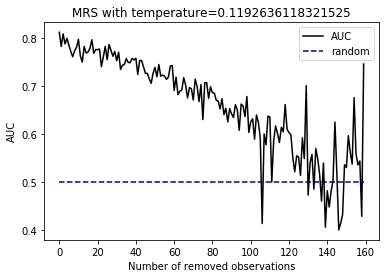

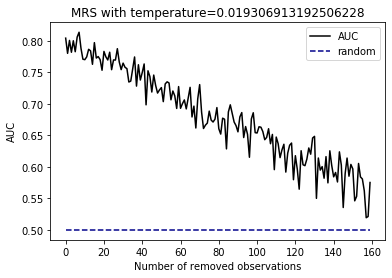

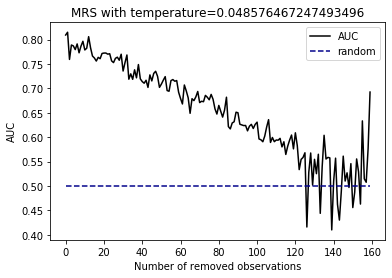

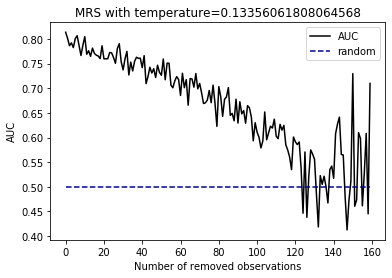

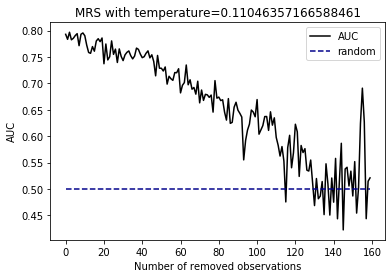

In [161]:
plot_auc_temp(aucs, temperatures)

### Experiment 2 b)
### <font color='darkgreen'>Gutenberg Brain Study (GBS) - Studie</font>  <a name="us"></a>

In [48]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

'''Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker', 'Zufriedenheit Leben', 'Aktiv',
       'Verärgert', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Druck', 'Optimismus Zukunft',
       'Zufriedenheit Wahlergebnis', 'Resilienz'''

N = gbs[columns].copy()
R = gesis[columns].copy()

N['label'] = 1
R['label'] = 0

In [49]:

X_train = pd.concat([N.head(len(N)//2), R.head(len(N)//2)])
X_test = pd.concat([N.tail(len(N)//2), R.tail(len(N)//2)])

y = (len(N)//2)*[1] + (len(N)//2)*[0]

# param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0,5, 1, 5, 10, 20, 100, 200, 500]}
mu, sigma = 0.4, 0.1 # mean and standard deviation
param_grid = {'C': np.random.normal(mu, sigma, 100)}

grid = GridSearchCV(LinearSVC(max_iter=2**20, dual=False), param_grid, verbose=3, cv=3)
grid.fit(X_train[columns], y)

print(grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] C=0.3505431360336403 ............................................
[CV] ................ C=0.3505431360336403, score=0.762, total=   0.0s
[CV] C=0.3505431360336403 ............................................
[CV] ................ C=0.3505431360336403, score=0.788, total=   0.0s
[CV] C=0.3505431360336403 ............................................
[CV] ................ C=0.3505431360336403, score=0.797, total=   0.0s
[CV] C=0.3573008720686892 ............................................
[CV] ................ C=0.3573008720686892, score=0.762, total=   0.0s
[CV] C=0.3573008720686892 ............................................
[CV] ................ C=0.3573008720686892, score=0.788, total=   0.0s
[CV] C=0.3573008720686892 ............................................
[CV] ................ C=0.3573008720686892, score=0.797, total=   0.0s
[CV] C=0.21456524876209598 ...........................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ............... C=0.35261561725388774, score=0.797, total=   0.0s
[CV] C=0.49697788628245104 ...........................................
[CV] ............... C=0.49697788628245104, score=0.762, total=   0.0s
[CV] C=0.49697788628245104 ...........................................
[CV] ............... C=0.49697788628245104, score=0.788, total=   0.0s
[CV] C=0.49697788628245104 ...........................................
[CV] ............... C=0.49697788628245104, score=0.797, total=   0.0s
[CV] C=0.41731619772990103 ...........................................
[CV] ............... C=0.41731619772990103, score=0.762, total=   0.0s
[CV] C=0.41731619772990103 ...........................................
[CV] ............... C=0.41731619772990103, score=0.788, total=   0.0s
[CV] C=0.41731619772990103 ...........................................
[CV] ............... C=0.41731619772990103, score=0.797, total=   0.0s
[CV] C=0.511690130310733 .............................................
[CV] .

[CV] ................ C=0.5039475181154079, score=0.788, total=   0.0s
[CV] C=0.5039475181154079 ............................................
[CV] ................ C=0.5039475181154079, score=0.797, total=   0.0s
[CV] C=0.43669487789610695 ...........................................
[CV] ............... C=0.43669487789610695, score=0.762, total=   0.0s
[CV] C=0.43669487789610695 ...........................................
[CV] ............... C=0.43669487789610695, score=0.788, total=   0.0s
[CV] C=0.43669487789610695 ...........................................
[CV] ............... C=0.43669487789610695, score=0.797, total=   0.0s
[CV] C=0.435407358789977 .............................................
[CV] ................. C=0.435407358789977, score=0.762, total=   0.0s
[CV] C=0.435407358789977 .............................................
[CV] ................. C=0.435407358789977, score=0.788, total=   0.0s
[CV] C=0.435407358789977 .............................................
[CV] .

[CV] ............... C=0.30756051620352204, score=0.797, total=   0.0s
[CV] C=0.332605929152438 .............................................
[CV] ................. C=0.332605929152438, score=0.762, total=   0.0s
[CV] C=0.332605929152438 .............................................
[CV] ................. C=0.332605929152438, score=0.788, total=   0.0s
[CV] C=0.332605929152438 .............................................
[CV] ................. C=0.332605929152438, score=0.797, total=   0.0s
[CV] C=0.26251464615076187 ...........................................
[CV] ............... C=0.26251464615076187, score=0.762, total=   0.0s
[CV] C=0.26251464615076187 ...........................................
[CV] ............... C=0.26251464615076187, score=0.788, total=   0.0s
[CV] C=0.26251464615076187 ...........................................
[CV] ............... C=0.26251464615076187, score=0.797, total=   0.0s
[CV] C=0.3430092364789061 ............................................
[CV] .

[CV] C=0.2690936666534274 ............................................
[CV] ................ C=0.2690936666534274, score=0.797, total=   0.0s
[CV] C=0.3426732796715936 ............................................
[CV] ................ C=0.3426732796715936, score=0.762, total=   0.0s
[CV] C=0.3426732796715936 ............................................
[CV] ................ C=0.3426732796715936, score=0.788, total=   0.0s
[CV] C=0.3426732796715936 ............................................
[CV] ................ C=0.3426732796715936, score=0.797, total=   0.0s
[CV] C=0.25664646181714856 ...........................................
[CV] ............... C=0.25664646181714856, score=0.762, total=   0.0s
[CV] C=0.25664646181714856 ...........................................
[CV] ............... C=0.25664646181714856, score=0.788, total=   0.0s
[CV] C=0.25664646181714856 ...........................................
[CV] ............... C=0.25664646181714856, score=0.797, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.5s finished


In [51]:
clf = CalibratedClassifierCV(LinearSVC(C=0.43, max_iter=2**20, dual=False))
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 3)

gesis_gbs = pd.concat([N, R])

aucs = repeated_MRS(gesis_gbs, columns, clf, temperatures, number_of_iterations=160, split_size=50, n_drop=3, k=1, test_size=0.5)

0    4249
1     119
Name: label, dtype: int64
0    4249
1     106
Name: label, dtype: int64
0    4249
1     112
Name: label, dtype: int64


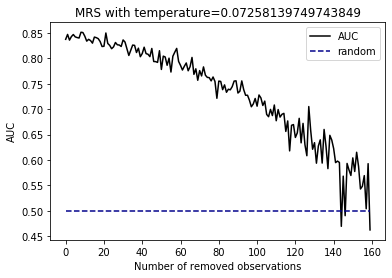

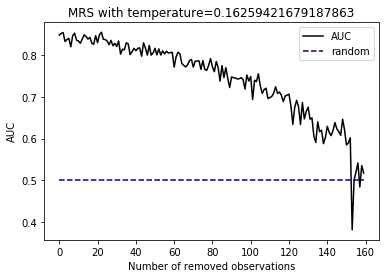

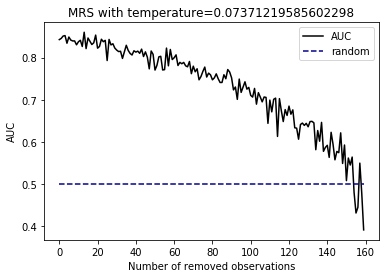

In [52]:
plot_auc_temp(aucs, temperatures)